# <center> $\Psi$(y,Z) remapped from T-space </center> #

* **Psi** = remapped stream function:
  $\psi$(y,T(y,z)) put in terms of $\psi(y,Z)$
  This uses a linear interpolation to match grids and temperature bands
  
* **Psi Ed** = Eddy stream function
  $\psi_{eddy}=\psi_{res}(y,Z)-\overline{\psi(y,Z)}$
  
* **K** = Eddy diffusivity
  $K=-\psi_{eddy}\frac{\overline{b_z}}{\overline{b_y}}$
  As from GM90 eddy parameterisation the eddy circulation can be thought of as this diffusivity multipied by isopycnal slope
  
Script overview:

1. Chose one of the above pannels to plot

2. Give it the file pattern (i.e. Where to search and what years do I want!). Do you want all runs possible? (pick Y or N)

3. Load in modules

4. Now before starting best to load in constant Variables such as grid parameters and constants.

5. Go into the main loop that's gonna read in the layers package data, calcuate the RMOC and then read in the temp field and find the depths of those temperatures and replot. Then calculate K and Eddy overturning. 

In [2]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [3]:
# Load in Modules
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import sys
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from HB_Plot import nf, fmt
import useful
import SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [4]:
fname = x+'/3daynokpp/'
c = utils.ChannelSetup(output_dir=str(fname))

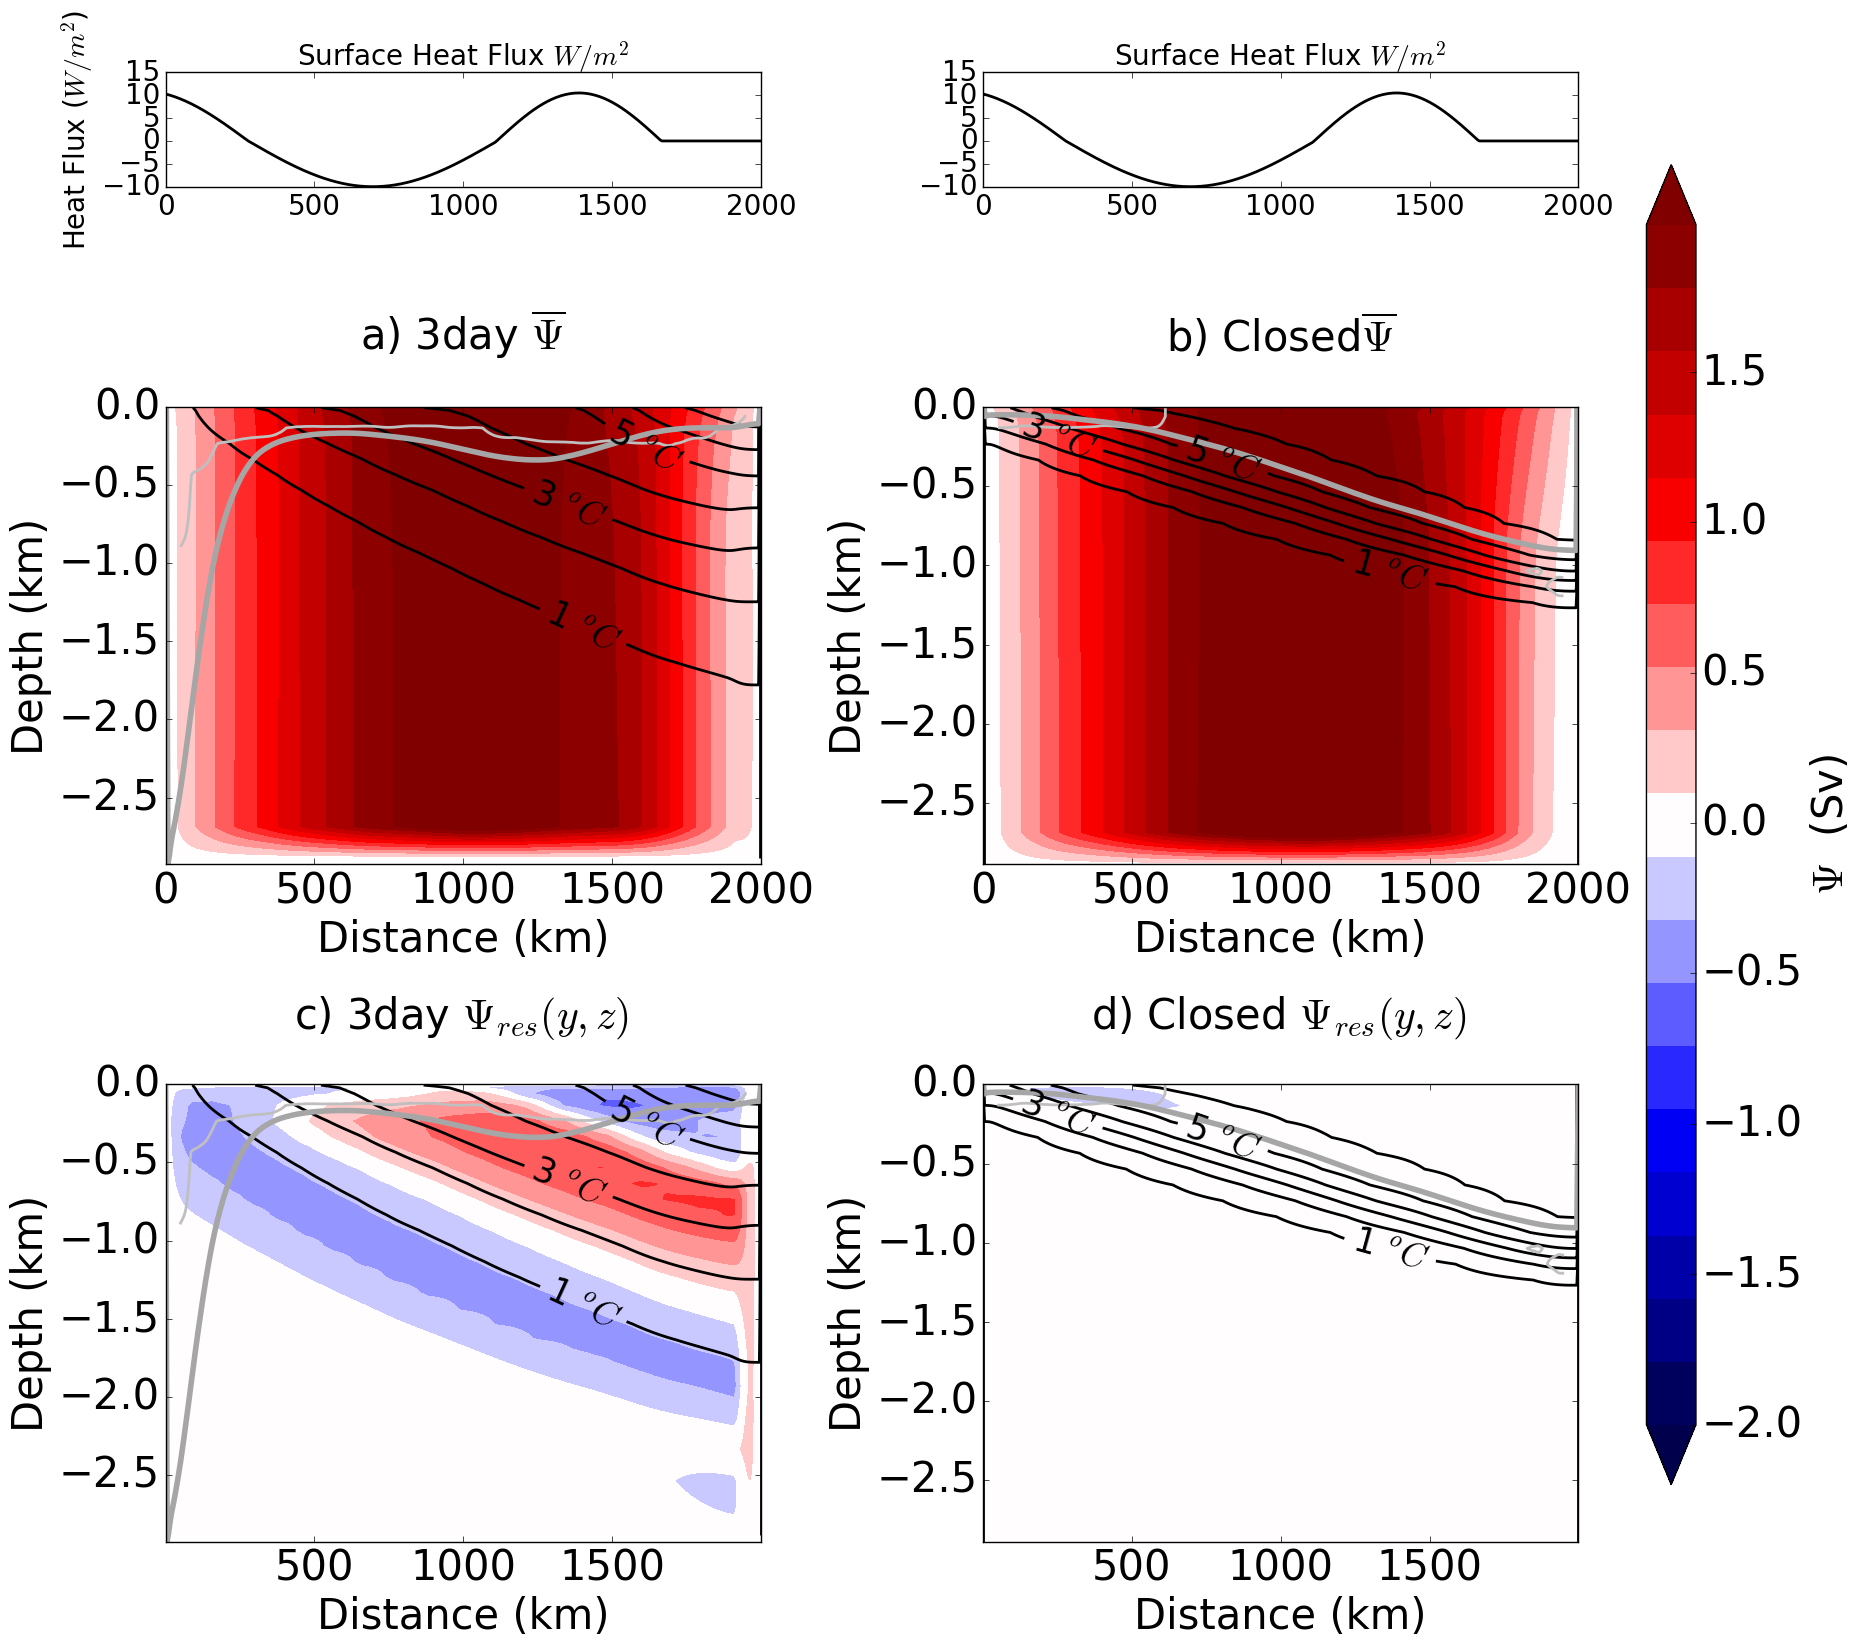

In [12]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
Psi_levs = np.arange(-2., 2., .21)
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 4, 4, 4])
ax = plt.subplot(gs[3])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
ax = plt.subplot(gs[0])
ax.plot(c.yc/1000,-Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
ax.plot(c.yc/1000,-Q,  color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    Psi = c.get_psi_iso_z()/10**6
    psi = c.get_psi_bar()/10**6
    ax1 = plt.subplot(gs[2+i])
    ax = plt.subplot(gs[4+i])
    Q2_levs = (np.arange(-1,8,1))
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan   
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q1 = ax1.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    yp = c.yg/1000
    p2 = ax1.contourf(yp, c.zc/1000, psi, Psi_levs,
                    cmap=plt.cm.seismic,extend='both')
    q.levels = [nf(val) for val in q.levels]
    q1.levels = [nf(val) for val in q1.levels]
    plt.clabel(q1, q1.levels[::2], inline=1, fmt=fmt, fontsize=25)
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    r1 = ax1.plot(c.yc/1000,-mld.mean(axis=1)/1000,scalex=False,scaley=False, color='0.65', linewidth=4)
    r = ax.plot(c.yc/1000,-mld.mean(axis=1)/1000,scalex=False,scaley=False, color='0.65', linewidth=4)
        
    r2 = ax1.contour(c.yg[10:-10]/1000, c.zc/1000, np.apply_along_axis(SG.savitzky_golay,1,PIz,17,1)[:,10:-10], [1-(0.5*10**-4)],
                   colors='0.75', linewidths=2)
    r3 = ax.contour(c.yg[10:-10]/1000, c.zc/1000, np.apply_along_axis(SG.savitzky_golay,1,PIz,17,1)[:,10:-10], [1-(0.5*10**-4)],
                   colors='0.75', linewidths=2)
    ax.set_title(str(Figletter[Runs[i]+2])+str(tau[Runs[i]])+'day $\Psi _{res}(y,z)$ \n', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]+2])+str(tau[Runs[i]])+' $ \Psi _{res}(y,z)$ \n', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax1.set_title('\n'+str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day $\overline{\Psi}$ \n', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax1.set_title('\n'+str(Figletter[Runs[i]])+str(tau[Runs[i]])+'$ \overline{\Psi}$ \n', fontsize=30)
    ax1.set_xlabel('Distance (km)', fontsize=30)
    ax1.set_ylabel('Depth (km)', fontsize=30)
    ax1.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)